In [1]:
# Standard Python libraries
import sys
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt

# For reading segy data
from obspy.io.segy.segy import _read_segy

#For writing segy data
from obspy import read, Trace, Stream, UTCDateTime
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader


# A. Read in text data

In [2]:
# Set the filename
f = open("userdata/P-impedance_2400-3000ms.gslib",'r')

#Read in all the lines in the file and save them to a variable
mylist = f.readlines()

#Close the file
f.close()
print("Done reading file. Number of lines:", len(mylist))

Done reading file. Number of lines: 3957609


In [3]:
#Have a look at the top of the data
for line in mylist[0:11]:
    print(line)

PETREL: Properties

7

i_index unit1 scale1

j_index unit1 scale1

k_index unit1 scale1

x_coord unit1 scale1

y_coord unit1 scale1

z_coord unit1 scale1

P-Impedance unit1 scale1

127 1 300 438131.65314303 6475378.74871708 -2999.00000000 9556.294922 

128 1 300 438181.65314303 6475378.74871708 -2999.00000000 9627.205078 



In [4]:
# A few ways to map this to a useful python format. But the simplest may be the following
data = []

#Skip the header rows
for line in mylist[9:]:
    linesplit = line.split()
    
    i = int(linesplit[0])
    j = int(linesplit[1])
    k = int(linesplit[2])
    x = float(linesplit[3])
    y = float(linesplit[4])
    z = float(linesplit[5])
    p = float(linesplit[6])
    
    data.append([i,j,k,x,y,z,p])


In [5]:
#Put the list in a dataframe
df=pd.DataFrame(data)

#Then free up some memory (because this is a fairly big chunk of data)
data=None

#Set the names of the columns of the dataframe
df.columns=['i','j','k','x','y','z','p']

df

,i,j,k,x,y,z,p
0,127,1,300,438131.653143,6.475379e+06,-2999.0,9556.294922
1,128,1,300,438181.653143,6.475379e+06,-2999.0,9627.205078
2,129,1,300,438231.653143,6.475379e+06,-2999.0,9555.066406
3,130,1,300,438281.653143,6.475379e+06,-2999.0,9468.100586
4,123,2,300,437931.653143,6.475429e+06,-2999.0,9601.517578
...,...,...,...,...,...,...,...
3957595,26,127,1,433081.653143,6.481679e+06,-2401.0,5848.801758
3957596,27,127,1,433131.653143,6.481679e+06,-2401.0,5924.203125
3957597,28,127,1,433181.653143,6.481679e+06,-2401.0,6037.129883
3957598,29,127,1,433231.653143,6.481679e+06,-2401.0,5978.708984


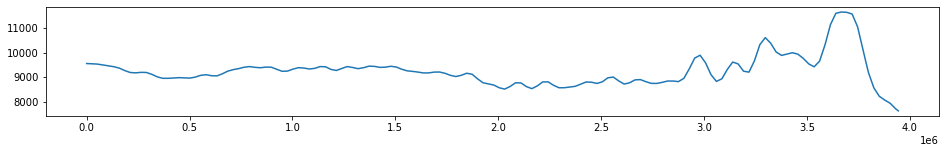

In [6]:
#Plot a single trace to see everything looks okay
one_trace = df[(df.i==127) & (df.j==1)].p

plt.figure(figsize=(16,2))
plt.plot(one_trace)
plt.show()

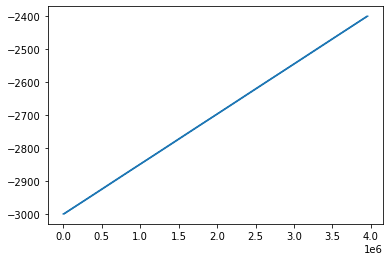

In [11]:
plt.plot(df.z)

# B. Read in equivalent segy data.
Get the segy header information from here, and just see what the goal is for the conversion.

In [7]:
stream = None 
stream = _read_segy("userdata/P-impedance_2400-3000ms.sgy", headonly=True)
print(np.shape(stream.traces))
stream

(216540,)


216540 traces in the SEG Y structure.

In [20]:
arrs=[]
for index, one_trace in enumerate(stream.traces):
    p = one_trace.data
    lenp = len(p)
    i = np.full((lenp), index,dtype=int)
    j = np.full((lenp), one_trace.header.ensemble_number,dtype=int)
    k = np.arange(lenp,0,-1,dtype=int)
    x = np.full((lenp), one_trace.header.source_coordinate_x)
    y = np.full((lenp), one_trace.header.source_coordinate_y)
    z = np.full((lenp), one_trace.header.original_field_record_number)
    
    temparr = np.c_[i,j,k,x,y,z,p]
    arrs.append(temparr)
    
arrs = np.vstack(arrs)


In [37]:
arrs[-1]

array([2.16539000e+05, 2.50000000e+03, 1.00000000e+00, 4.32975000e+05,
       6.48179200e+06, 1.03610000e+04, 9.38641016e+03])

In [39]:
header ="PETREL: Properties\n7\n\ni_index unit1 scale1\nj_index unit1 scale1\nk_index unit1 scale1\nx_coord unit1 scale1\ny_coord unit1 scale1\nz_coord unit1 scale1\nP-Impedance unit1 scale1\n"
np.savetxt("data.txt", arrs,header=header, comments='', fmt="%i %i %i %i %i %i %f")

Trace sequence number within line: 0
151 samples, dtype=float32, 250.00 Hz


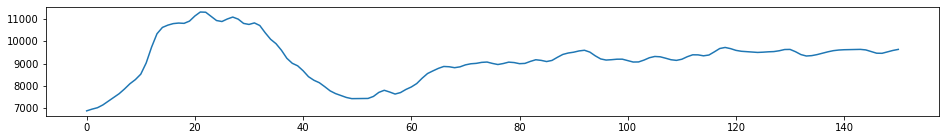

In [9]:
one_trace = stream.traces[100]

#Print out details single trace
print(one_trace)

#Plot a single trace to see everything looks okay
plt.figure(figsize=(16,2))
plt.plot(one_trace.data)
plt.show()

In [9]:
#Here is the header information - for one trace
stream.traces[0].header

trace_sequence_number_within_line: 0
trace_sequence_number_within_segy_file: 0
original_field_record_number: 9961
trace_number_within_the_original_field_record: 0
energy_source_point_number: 0
ensemble_number: 1961
trace_number_within_the_ensemble: 0
trace_identification_code: 0
number_of_vertically_summed_traces_yielding_this_trace: 0
number_of_horizontally_stacked_traces_yielding_this_trace: 0
data_use: 0
distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group: 0
receiver_group_elevation: 0
surface_elevation_at_source: 0
source_depth_below_surface: 0
datum_elevation_at_receiver_group: 0
datum_elevation_at_source: 0
water_depth_at_source: 0
water_depth_at_group: 0
scalar_to_be_applied_to_all_elevations_and_depths: 0
scalar_to_be_applied_to_all_coordinates: 0
source_coordinate_x: 438302
source_coordinate_y: 6475310
group_coordinate_x: 0
group_coordinate_y: 0
coordinate_units: 0
weathering_velocity: 0
subweathering_velocity: 0
uphole_time_at_source_in_ms: 0
uphole_t

# C. Write out the text data as segy

In [10]:
# Group all the text traces by their the i-j coordinates
groups=df.groupby(['i','j'])
print(len(groups))

#Here I notice there are only 13192 traces in the text data, compared with the 216540 in the segy data...

13192


In [11]:
%%time

#Make a stream object (flush it out to begin because we have used this variable names for demos)
stream_out = None 
stream_out = Stream()

#not sure how to group the trace ensembles but can use a counter to keep track of them
ensemble_number = 0
       
for ids,df_trace in groups:
    #ids are the i, j coordinate locations
    #trc is the subset of the full dataframe for just that i-j location

    #For each i-j location, a trace is impdence at all the depth values, i.e.
    data = df_trace.p.values

    # Enforce correct byte number and set to the Trace object
    data = np.require(data, dtype=np.float32)
    trace = Trace(data=data)

    # Set all the segy header information
    # Attributes in trace.stats will overwrite everything in trace.stats.segy.trace_header
    trace.stats.delta = 0.01
    trace.stats.starttime = UTCDateTime(1970,1,1,0,0,0)

    # If you want to set some additional attributes in the trace header,
    # add one and only set the attributes you want to be set. Otherwise the
    # header will be created for you with default values.
    if not hasattr(trace.stats, 'segy.trace_header'):
        trace.stats.segy = {}

    trace.stats.segy.trace_header = SEGYTraceHeader()

#         trace.stats.segy.trace_header.trace_sequence_number_within_line = index + 1
#         trace.stats.segy.trace_header.receiver_group_elevation = 0
    trace.stats.segy.trace_header.source_coordinate_x = int(df_trace.x.values[0])
    trace.stats.segy.trace_header.source_coordinate_y = int(df_trace.y.values[0])
    trace.stats.segy.trace_header.ensemble_number = ensemble_number #Not sure how this is actually determined
    trace.stats.segy.trace_header.lag_time_A = 2400
    trace.stats.segy.trace_header.lag_time_B = 3000
    trace.stats.segy.trace_header.number_of_samples_in_this_trace = len(data)

    ensemble_number +=1

    # Add trace to stream
    stream_out.append(trace)

# A SEGY file has file wide headers. This can be attached to the stream
# object.  If these are not set, they will be autocreated with default
# values.
stream_out.stats = AttribDict()
stream_out.stats.textual_file_header = 'Textual Header!'
stream_out.stats.binary_file_header = SEGYBinaryFileHeader()
stream_out.stats.binary_file_header.trace_sorting_code = 5
# stream.stats.binary_file_header.number_of_data_traces_per_ensemble=1

print("Stream object before writing...")
print(stream_out)

stream_out.write("TEST.sgy", format="SEGY", data_encoding=1, byteorder=sys.byteorder)

print("Stream object after writing. Will have some segy attributes...")
print(stream_out)


Stream object before writing...
13192 Trace(s) in Stream:

... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.990000Z | 100.0 Hz, 300 samples
...
(13190 other traces)
...
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.990000Z | 100.0 Hz, 300 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Stream object after writing. Will have some segy attributes...
13192 Trace(s) in Stream:

Seq. No. in line:    0 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.990000Z | 100.0 Hz, 300 samples
...
(13190 other traces)
...
Seq. No. in line:    0 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:02.990000Z | 100.0 Hz, 300 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
CPU times: total: 7.55 s
Wall time: 7.52 s


In [12]:
#Now check it
print("Reading using obspy.io.segy...")
st1 = _read_segy("TEST.sgy")
print(st1)

print(np.shape(st1.traces))
st1

Reading using obspy.io.segy...
13192 traces in the SEG Y structure.
(13192,)


13192 traces in the SEG Y structure.

Trace sequence number within line: 0
300 samples, dtype=float32, 100.00 Hz


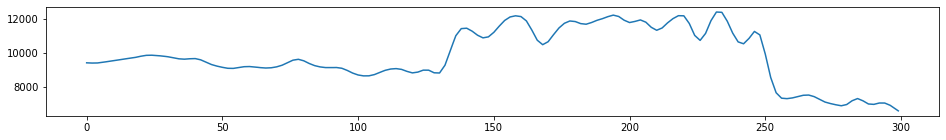

In [13]:
one_trace = st1.traces[0]

#Print out details single trace
print(one_trace)

#Plot a single trace
plt.figure(figsize=(16,2))
plt.plot(one_trace.data)
plt.show()

# Bonus - why is there a data discrepency
I would have expected the traces from the segy data and from the gslib data to match up.
But there are only 13192 traces in the text data and 216540 in the segy data.
Something weird is going. I can plot these side by side and see if some data are missing.

In [14]:
xx=[]
yy=[]
for i in range(len(stream.traces)):
    xx.append(stream.traces[i].header.source_coordinate_x)
    yy.append(stream.traces[i].header.source_coordinate_y)  

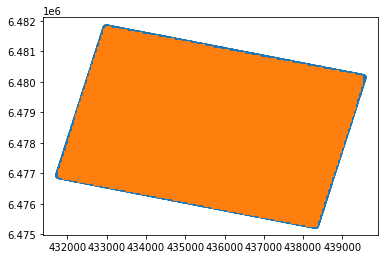

In [15]:
plt.scatter(xx,yy)
plt.scatter(df.x,df.y)

At first glance this seems ok. The data coverage is over the same area, the edges are missing buuuuut zooming in we can see the text data is not as dense as the segy data. Problem solved.

(433000.0, 434000.0)

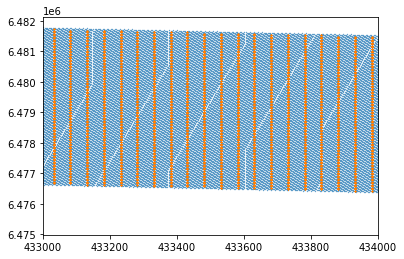

In [16]:
plt.scatter(xx,yy,s=0.1)
plt.scatter(df.x,df.y,s=0.1)

plt.xlim([433000,434000])
# plt.ylim([433000,434000])